# <span style="color:MediumSeaGreen">Carsharing Startup Analysis</span>
 <span style="color:MediumSeaGreen">Upfront pricing precision</span>

### <span style="color:MediumSeaGreen">Columns Detail</span>

- **order_id_new**: ID of an order
- **order_try_id_new**: ID of an order “attempt” (one order can be attempted on multiple drivers, until one accepts)
- **Metered_price, distance & duration**: Actual price, distance and duration of a ride
- **upfront_price**: Promised to the rider price, based on predicted duration (predicted_duration) and distance (predicted_distance)
- **distance**: Ride distance
- **duration**: Ride Duration
- **gps_confidence**: Indicator for good GPS connection (1 - good one, 0 - bad one)
- **entered_by**: Who entered the address
- **b_state**: State of a ride (finished implies that the ride was actually done)
- **dest_change_number**: Number of destination changes by a rider and a driver. It includes the original input of the destination by a rider. That is why the minimum value of it is 1
- **predicted_distance**: Predicted duration of a ride based on the pickup and dropoff points entered by the rider requesting a car
- **predicted_duration**: Predicted duration of a ride based on the pickup and dropoff points entered by the rider requesting a car
- **prediction_price_type**: Internal variable for the type of prediction:
    - *upfront, prediction - prediction happened before the ride*
    - *upfront_destination_changed - prediction happened after rider changed destination during the ride*
- **change_reason_pricing**: Indicates whose action triggered a change in the price prediction. If it is empty, it means that either nobody changed the destination or that the change has not affected the predicted price
- **ticket_id_new**: ID for customer support ticket
- **device_token, device_token_new**: ID for a device_token (empty for all the fields)
- **rider_app_version**: App version of rider phone
- **driver_app_version**: App version of driver phone
- **driver_device_uid_new**: ID for UID of a phone device
- **device_name**: The name of the phone
- **eu_indicator**: Whether a ride happens in EU
- **overpaid_ride_ticket**: Indicator for a rider complaining about the overpaid ride
- **fraud_score**: Fraud score of a rider. The higher it is the more likely the rider will cheat.



### <span style="color:MediumSeaGreen">Libraries and Dataframe</span>

In [27]:
import pandas as pd
import numpy as np
from funpymodeling.exploratory import freq_tbl, profiling_num, status, corr_pair
import datetime as dt
import math
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from matplotlib.cm import get_cmap
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('Data/Test.csv')
df_raw = pd.read_csv('Data/Test.csv')

## <span style="color:MediumSeaGreen">Data Preparation</span>

#### <span style="color:MediumSeaGreen">First Approach</span>

In [3]:
# Obtaining an overview of the available columns and initial exploration of their contents.
df.head(3)

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,dest_change_number,prediction_price_type,predicted_distance,predicted_duration,change_reason_pricing,ticket_id_new,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,fraud_score
0,22,22,2020-02-02 3:37:31,4.04,10.0,2839,700,1,client,finished,1,upfront,13384.0,1091.0,NaN,1376,NaN,CI.4.17,finished,finished,DA.4.37,1596,Xiaomi Redmi 6,1,0,-1383.0
1,618,618,2020-02-08 2:26:19,6.09,3.6,5698,493,1,client,finished,1,upfront,2286.0,360.0,NaN,2035,NaN,CA.5.43,finished,finished,DA.4.39,1578,Samsung SM-G965F,1,0,NaN
2,657,657,2020-02-08 11:50:35,4.32,3.5,4426,695,1,client,finished,1,upfront,4101.0,433.0,NaN,2222,NaN,CA.5.43,finished,finished,DA.4.37,951,Samsung SM-A530F,1,0,-166.0


In [4]:
# Summarizing the presence of null values and data types for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4943 entries, 0 to 4942
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_id_new           4943 non-null   int64  
 1   order_try_id_new       4943 non-null   int64  
 2   calc_created           4943 non-null   object 
 3   metered_price          4923 non-null   float64
 4   upfront_price          3409 non-null   float64
 5   distance               4943 non-null   int64  
 6   duration               4943 non-null   int64  
 7   gps_confidence         4943 non-null   int64  
 8   entered_by             4943 non-null   object 
 9   b_state                4943 non-null   object 
 10  dest_change_number     4943 non-null   int64  
 11  prediction_price_type  4923 non-null   object 
 12  predicted_distance     4923 non-null   float64
 13  predicted_duration     4923 non-null   float64
 14  change_reason_pricing  298 non-null    object 
 15  tick

In [5]:
# Identifying columns with duplicate values and distinguishing them from columns with unique values.
df.nunique()/df.count() == 1

order_id_new             False
order_try_id_new         False
calc_created             False
metered_price            False
upfront_price            False
distance                 False
duration                 False
gps_confidence           False
entered_by               False
b_state                  False
dest_change_number       False
prediction_price_type    False
predicted_distance       False
predicted_duration       False
change_reason_pricing    False
ticket_id_new             True
device_token             False
rider_app_version        False
order_state              False
order_try_state          False
driver_app_version       False
driver_device_uid_new    False
device_name              False
eu_indicator             False
overpaid_ride_ticket     False
fraud_score              False
dtype: bool

In [6]:
# Examining the orders to determine which ones are repeated or duplicated
df['order_id_new'].value_counts().sort_values() > 1

2446    False
833     False
3857    False
1055    False
1171    False
        ...  
761      True
4105     True
774      True
3443     True
63       True
Name: order_id_new, Length: 4166, dtype: bool

In [7]:
# Fetching an instance of a repeated order to gain insights into columns with varying values
df[df['order_id_new']==63].nunique()

order_id_new             1
order_try_id_new         1
calc_created             1
metered_price            1
upfront_price            1
distance                 1
duration                 1
gps_confidence           1
entered_by               1
b_state                  1
dest_change_number       1
prediction_price_type    1
predicted_distance       1
predicted_duration       1
change_reason_pricing    0
ticket_id_new            6
device_token             0
rider_app_version        1
order_state              1
order_try_state          1
driver_app_version       1
driver_device_uid_new    1
device_name              1
eu_indicator             1
overpaid_ride_ticket     2
fraud_score              0
dtype: int64

In [8]:
# Calculate the percentage of null values in each column
df.isnull().mean() * 100

order_id_new               0.000000
order_try_id_new           0.000000
calc_created               0.000000
metered_price              0.404613
upfront_price             31.033785
distance                   0.000000
duration                   0.000000
gps_confidence             0.000000
entered_by                 0.000000
b_state                    0.000000
dest_change_number         0.000000
prediction_price_type      0.404613
predicted_distance         0.404613
predicted_duration         0.404613
change_reason_pricing     93.971273
ticket_id_new              0.000000
device_token             100.000000
rider_app_version          0.323690
order_state                0.000000
order_try_state            0.000000
driver_app_version         0.000000
driver_device_uid_new      0.000000
device_name                0.000000
eu_indicator               0.000000
overpaid_ride_ticket       0.000000
fraud_score               55.816306
dtype: float64

In [9]:
# Analyze the distribution of numerical variables.
profiling_num(df)

,variable,mean,std_dev,variation_coef,p_0.01,p_0.05,p_0.25,p_0.5,p_0.75,p_0.95,p_0.99
0,order_id_new,2061.074449,1199.298429,0.581880,40.4200,199.10,1020.50,2065.00,3090.50,3947.900,4121.5800
1,order_try_id_new,2061.074044,1199.299081,0.581881,40.4200,199.10,1020.50,2065.00,3090.50,3947.900,4121.5800
2,metered_price,7998.471296,15815.850352,1.977359,2.4044,2.75,5.38,13.35,10991.67,33581.662,73460.1088
3,upfront_price,4160.095747,17015.711912,4.090221,2.2000,2.60,4.20,6.60,4000.00,18500.000,42960.0000
4,distance,9769.223144,10912.426401,1.117021,0.0000,276.20,3785.50,7140.00,11953.00,28109.500,52230.3400
5,duration,1566.230629,1650.329858,1.053695,6.0000,166.00,604.00,1054.00,1929.50,4635.000,8164.0000
6,gps_confidence,0.800728,0.399493,0.498912,0.0000,0.00,1.00,1.00,1.00,1.000,1.0000
7,dest_change_number,1.119361,0.499611,0.446336,1.0000,1.00,1.00,1.00,1.00,2.000,3.0000
8,predicted_distance,8822.636807,10548.801733,1.195652,953.4400,1901.30,4130.50,6918.00,10674.00,20916.300,39417.0000
9,predicted_duration,1106.737355,806.098535,0.728356,177.4400,334.10,597.50,939.00,1427.00,2397.500,3365.4600


#### <span style="color:MediumSeaGreen">Transformations</span>

In [10]:
#---------------------- Remove rows with null values in the upfront or metered price columns.

# Null values in upfront price: Quick analysis for trends due to high cases
upfront_null_values = df[df['upfront_price'].isnull()]

df = df.dropna(subset=['upfront_price','metered_price'])

# Remove orders where both distance and duration are 0
df = df[~((df['duration']==0) & (df['distance']==0))]


In [11]:
#---------------------- Implementing a process to extract a single row per ticket, eliminating duplicates

# Consolidating all ticket IDs for each order into a single column through grouping
order_tickets = df.groupby('order_id_new').agg({'ticket_id_new': 
                                                lambda x: ', '.join(x.astype(str))}).reset_index().rename(columns={'ticket_id_new':'ticket_id_grouped'})

# Calculating the total count of tickets for each order
tickets_per_order = df.groupby('order_id_new')['ticket_id_new'].nunique().reset_index().rename(columns={'ticket_id_new':'total_tickets_per_order'})

# Calculate the total number of tickets associated with overpaid complaints
overpaid_ticket_per_order = df.groupby('order_id_new')['overpaid_ride_ticket'].sum().reset_index().rename(
    columns={'overpaid_ride_ticket':'overpaid_tickets_per_order'})

# Utilize previously created variables to add new columns to the DataFrame
df = pd.merge(df,order_tickets,how='left',on='order_id_new')
df = pd.merge(df,tickets_per_order,how='left',on='order_id_new')
df = pd.merge(df,overpaid_ticket_per_order,how='left',on='order_id_new')

# Drop repated columns 
df = df.drop(['ticket_id_new','overpaid_ride_ticket'],axis=1)

# Drop duplicates to get a row per order
df.drop_duplicates(inplace=True)

In [12]:
#---------------------- Adjust data types as needed

#Convert the date field to a datetime format.
df['calc_created'] = pd.to_datetime(df['calc_created'])
df['eu_indicator'] = df['eu_indicator'].astype('str')
df['driver_device_uid_new'] = df['driver_device_uid_new'].astype('str')
df['gps_confidence'] = df['gps_confidence'].astype('str')
df['order_id_new'] = df['order_id_new'].astype('str')
df['order_try_id_new'] = df['order_try_id_new'].astype('str')


#---------------------- Create additional columns to support our analysis


# Calculate the variance between the metered price and the upfront price to gain insight into the actual payment made by the client.
df['price_variation'] = np.sqrt((df['metered_price'] / df['upfront_price']-1)**2)

# Calculate the deviation between the predicted distance, duration, and the actual distance, duration in order to gain a deeper understanding of the price fluctuations.
df['distance_variation'] = np.sqrt((df['distance'] / df['predicted_distance']-1)**2)
df['duration_variation'] = np.sqrt((df['duration'] / df['predicted_duration']-1)**2)

# Add a boolean column for price change based on metered price variance (>20%)
df['change_price'] = df['price_variation'] > 0.2

# Extract the first word from the device name to obtain the brand.
df['device_brand'] = df['device_name'].str.split().str[0]

# Check if metered price is higher than predicted price, with null values indicating equality.
df['metered_higher'] = (df['metered_price'] - df['upfront_price']) > 0
df.loc[df['metered_price'] == df['upfront_price'], 'metered_higher'] = np.nan

#
df['driver_operative_system'] = df['driver_app_version'].str[:2]
df['rider_operative_system'] = df['rider_app_version'].str[:2]

# Extract date, day of the week, month, and hour from the calculation creation date

df['date'] = df['calc_created'].dt.date
df['day_of_the_week']= df['calc_created'].dt.day_name()
df['month'] = df['calc_created'].dt.month_name()
df['hour_of_the_day']= df['calc_created'].dt.hour
df['day_of_the_week_number'] = df['calc_created'].dt.day_of_week

# Calculate the predicted minutes for each kilometer
df['distance_per_minute_predicted'] = df['distance']/df['duration']


#---------------------- Remove irrelevant columns from the DataFrame

df = df.drop('device_token',axis=1)


In [13]:
# Clean outliers from the dataset to make a better analysis
def remove_outliers(df, column, z_threshold):
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    df_cleaned = df[z_scores < z_threshold]
    return df_cleaned

# Set the z-score threshold
z_threshold = 3

# Remove outliers from the 'price_variation' column
df = remove_outliers(df, 'price_variation', z_threshold)

#### <span style="color:MediumSeaGreen">Validation</span>

In [14]:
# Verify the correctness of data types.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2875 entries, 0 to 3387
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id_new                   2875 non-null   object        
 1   order_try_id_new               2875 non-null   object        
 2   calc_created                   2875 non-null   datetime64[ns]
 3   metered_price                  2875 non-null   float64       
 4   upfront_price                  2875 non-null   float64       
 5   distance                       2875 non-null   int64         
 6   duration                       2875 non-null   int64         
 7   gps_confidence                 2875 non-null   object        
 8   entered_by                     2875 non-null   object        
 9   b_state                        2875 non-null   object        
 10  dest_change_number             2875 non-null   int64         
 11  prediction_price_

In [15]:
# Verify that each order has a single corresponding row
df.nunique()/df.count() == 1

order_id_new                      True
order_try_id_new                  True
calc_created                     False
metered_price                    False
upfront_price                    False
distance                         False
duration                         False
gps_confidence                   False
entered_by                       False
b_state                          False
dest_change_number               False
prediction_price_type            False
predicted_distance               False
predicted_duration               False
change_reason_pricing            False
rider_app_version                False
order_state                      False
order_try_state                  False
driver_app_version               False
driver_device_uid_new            False
device_name                      False
eu_indicator                     False
fraud_score                      False
ticket_id_grouped                 True
total_tickets_per_order          False
overpaid_tickets_per_orde

In [16]:
# Evaluate the adequacy of null value percentages for important columns
df.isnull().mean() * 100

order_id_new                      0.000000
order_try_id_new                  0.000000
calc_created                      0.000000
metered_price                     0.000000
upfront_price                     0.000000
distance                          0.000000
duration                          0.000000
gps_confidence                    0.000000
entered_by                        0.000000
b_state                           0.000000
dest_change_number                0.000000
prediction_price_type             0.000000
predicted_distance                0.000000
predicted_duration                0.000000
change_reason_pricing            99.130435
rider_app_version                 0.000000
order_state                       0.000000
order_try_state                   0.000000
driver_app_version                0.000000
driver_device_uid_new             0.000000
device_name                       0.000000
eu_indicator                      0.000000
fraud_score                      39.547826
ticket_id_g

## <span style="color:MediumSeaGreen">Analysis</span>

#### <span style="color:MediumSeaGreen">Understanding the problem</span>

In [17]:
# Calculate the percentage of orders that experienced price changes
print('Percentage of orders that experienced price changes: \n\n',
      round((df['change_price'].value_counts()[1] / df['change_price'].shape[0]) * 100,2),
     '%\n \n-----------------------------')

# Calculate the percentage of orders where the predicted value exactly matches the metered value
print('Percentage of orders where the predicted value exactly matches the metered value \n\n',
      round((df[df['metered_higher'].isnull()]['order_id_new'].count()/df.count()['order_id_new'])*100,2),
     '%\n \n-----------------------------')

# Calculate the percentage of orders where the metered price is higher than the predicted price
print('Percentage of orders where metered price is higher than the predicted price \n\n',
      round((df['metered_higher'].value_counts()[1]/df['order_id_new'].shape[0])*100,2),
     '%\n \n-----------------------------')

# Calculate the percentage of orders where the metered price is higher than the predicted price when the final price remains unchanged
print('Percentage of orders where metered price is higher than predicted but the final price remains unchanged \n\n',
      round((df[df['change_price']==False]['metered_higher'].value_counts()[1]/df[df['change_price']==False]['order_id_new'].shape[0])*100,2),
     '%\n \n-----------------------------')

# Calculate the percentage of orders that have tickets with overprice complaints.
print('Percentage of orders that have tickets with overprice complaints \n\n',
      round((df[df['overpaid_tickets_per_order']>0]['order_id_new'].count()/df['order_id_new'].shape[0])*100,2),
     '%\n \n-----------------------------')

# Calculate the total number of orders that have tickets with overprice complaints.
print('Total orders that have tickets with overprice complaints \n\n',
      df[df['overpaid_tickets_per_order']>0]['order_id_new'].count(),
     '\n \n-----------------------------')

# Total Orders Analized
print('Total orders  \n\n',
      df.count()['order_id_new'],
     '\n \n-----------------------------')

# Analyzed time period.
print('Start date of the analyzed period:  \n\n',
      df['calc_created'].dt.to_period('d').min(),
      '\n\n End date of the analyzed period: \n\n',
      df['calc_created'].dt.to_period('d').max(),
     '\n \n-----------------------------')


Percentage of orders that experienced price changes: 

 44.17 %
 
-----------------------------
Percentage of orders where the predicted value exactly matches the metered value 

 4.77 %
 
-----------------------------
Percentage of orders where metered price is higher than the predicted price 

 58.05 %
 
-----------------------------
Percentage of orders where metered price is higher than predicted but the final price remains unchanged 

 42.99 %
 
-----------------------------
Percentage of orders that have tickets with overprice complaints 

 3.13 %
 
-----------------------------
Total orders that have tickets with overprice complaints 

 90 
 
-----------------------------
Total orders  

 2875 
 
-----------------------------
Start date of the analyzed period:  

 2020-02-02 

 End date of the analyzed period: 

 2020-03-13 
 
-----------------------------


In [18]:
# Analyze the distribution of different variations (price, duration, distance).
profiling_num(df[['price_variation','distance_variation','duration_variation']])

,variable,mean,std_dev,variation_coef,p_0.01,p_0.05,p_0.25,p_0.5,p_0.75,p_0.95,p_0.99
0,price_variation,0.240509,0.284813,1.184209,0.000000,0.001279,0.041772,0.154054,0.321394,0.792981,1.463504
1,distance_variation,0.296333,0.430202,1.451749,0.000732,0.003905,0.034566,0.147580,0.416996,0.997957,1.536802
2,duration_variation,0.425598,0.799201,1.877830,0.003495,0.017169,0.093321,0.226141,0.531900,1.333656,2.964102


In [19]:
# Count the total number of orders in the raw dataset
df_raw['order_id_new'].nunique()

4166

#### <span style="color:MediumSeaGreen">Explore patterns and trends related to dates in the dataset.</span>

##### <span style="color:MediumSeaGreen">Analyze the behavior of orders based on hour of the day</span>

In [20]:
# ---------------------- Total orders

# Calculate the total count of orders for each hour of the day.
orders_by_hour = df.sort_values('hour_of_the_day').groupby('hour_of_the_day')['order_id_new'].count()

# Set x and y variables to represent the timeline data.
x = orders_by_hour.index.to_list()
y = orders_by_hour.values

# Calculate the mean, maximum, and minimum values for the entire period
mean = orders_by_hour.mean()
maximum = orders_by_hour.max()
minimum =orders_by_hour.min()


# ---------------------- Orders with price changed

# Calculate the total count of orders for each hour of the day.
changed_price_orders_by_hour = df[df['change_price']==True].sort_values('hour_of_the_day').groupby('hour_of_the_day')['order_id_new'].count()

# Set x and y variables to represent the timeline data.
x2 = changed_price_orders_by_hour.index.to_list()
y2 = changed_price_orders_by_hour.values

# Calculate the mean, maximum, and minimum values for the entire period
mean2 = changed_price_orders_by_hour.mean()
maximum2 = changed_price_orders_by_hour.max()
minimum2 = changed_price_orders_by_hour.min()

# ---------------------- Percentage orders with price changed

# Calculate the total count of orders for each hour of the day.
changed_price_orders_perc_by_hour = pd.merge(orders_by_hour.reset_index(),changed_price_orders_by_hour.
         reset_index(), how='left',on='hour_of_the_day').rename(columns={'order_id_new_x':'total_orders','order_id_new_y':'orders_with_price_changed'})

changed_price_orders_perc_by_hour['orders_with_price_changed_percentage'] = round(changed_price_orders_perc_by_hour['orders_with_price_changed'] 
                                                                                  / changed_price_orders_perc_by_hour['total_orders'],2)

changed_price_orders_perc_by_hour = changed_price_orders_perc_by_hour.groupby('hour_of_the_day')['orders_with_price_changed_percentage'].max()

# Set x and y variables to represent the timeline data.
x3 = changed_price_orders_perc_by_hour.index.to_list()
y3 = changed_price_orders_perc_by_hour.values

# Calculate the mean, maximum, and minimum values for the entire period
mean3 = changed_price_orders_perc_by_hour.mean()
maximum3 = changed_price_orders_perc_by_hour.max()
minimum3 = changed_price_orders_perc_by_hour.min()


# ---------------------- Average Price desviation 

# Calculate the total number of orders for each date
avg_price_variation_by_hour = df.sort_values('hour_of_the_day').groupby('hour_of_the_day')['price_variation'].mean()

# Set x and y variables to represent the timeline data.
x4 = avg_price_variation_by_hour.index.to_list()
y4 = avg_price_variation_by_hour.values

# Calculate the mean, maximum, and minimum values for the entire period
mean4 = avg_price_variation_by_hour.mean()
maximum4 = avg_price_variation_by_hour.max()
minimum4 = avg_price_variation_by_hour.min()

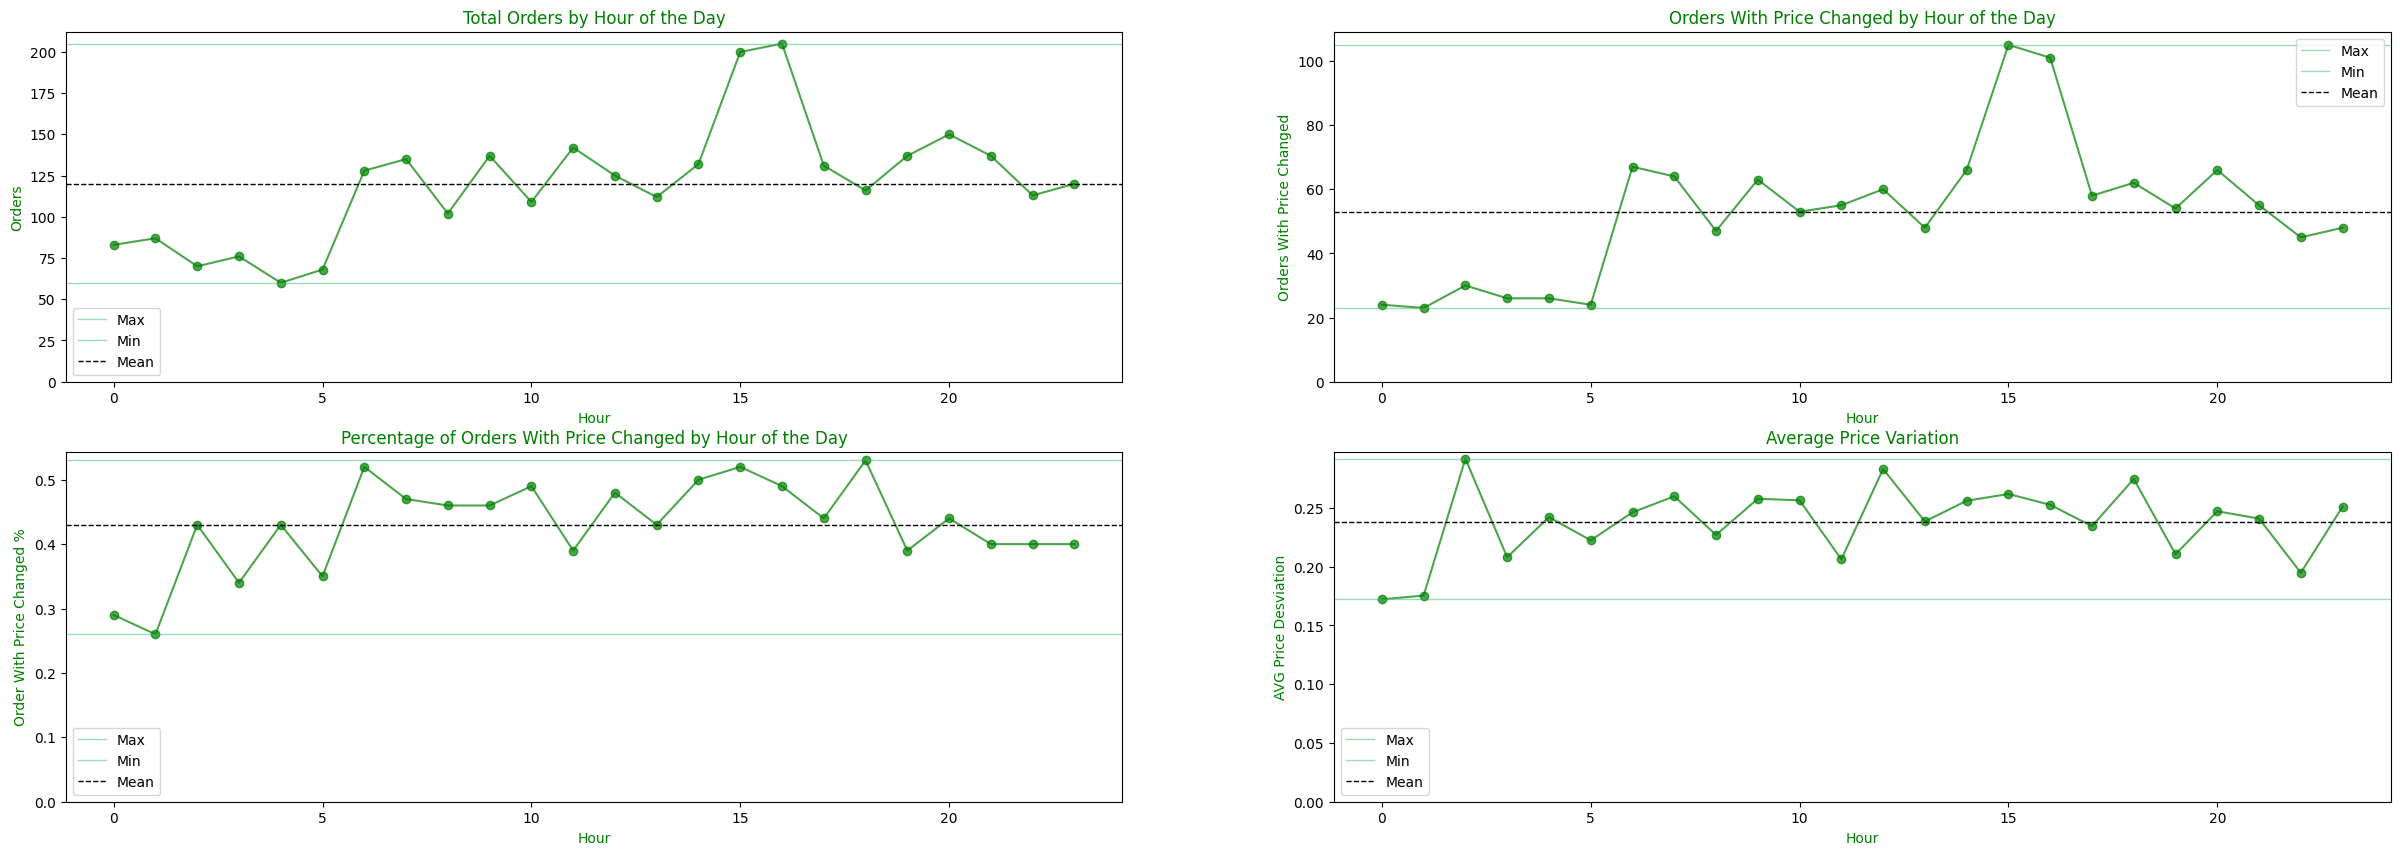

In [21]:
#Generate a timeline visualization

fig,ax = plt.subplots(nrows=2, ncols=2,figsize=(30,10))

ax[0,0].plot (x,y, marker='o',color='green',alpha=0.7)
ax[0,0].axhline(maximum, color='MediumSeaGreen',alpha=0.5,    linewidth=1, label='Max')
ax[0,0].axhline(minimum, color='MediumSeaGreen',alpha=0.5, linewidth=1, label='Min')
ax[0,0].axhline(mean, color='black', linestyle='--', linewidth=1, label='Mean')
ax[0,0].set_xlabel('Hour',color='green')
ax[0,0].set_ylabel('Orders',color='green')
ax[0,0].set_title('Total Orders by Hour of the Day',color='green')
ax[0,0].set_ylim(ymin=0)
ax[0,0].legend()

ax[0,1].plot (x2,y2, marker='o',color='green',alpha=0.7)
ax[0,1].axhline(maximum2, color='MediumSeaGreen',alpha=0.5,    linewidth=1, label='Max')
ax[0,1].axhline(minimum2, color='MediumSeaGreen',alpha=0.5, linewidth=1, label='Min')
ax[0,1].axhline(mean2, color='black', linestyle='--', linewidth=1, label='Mean')
ax[0,1].set_xlabel('Hour',color='green')
ax[0,1].set_ylabel('Orders With Price Changed',color='green')
ax[0,1].set_title('Orders With Price Changed by Hour of the Day',color='green')
ax[0,1].set_ylim(ymin=0)
ax[0,1].legend()

ax[1,0].plot (x3,y3, marker='o',color='green',alpha=0.7)
ax[1,0].axhline(maximum3, color='MediumSeaGreen',alpha=0.5,    linewidth=1, label='Max')
ax[1,0].axhline(minimum3, color='MediumSeaGreen',alpha=0.5, linewidth=1, label='Min')
ax[1,0].axhline(mean3, color='black', linestyle='--', linewidth=1, label='Mean')
ax[1,0].set_xlabel('Hour',color='green')
ax[1,0].set_ylabel('Order With Price Changed %',color='green')
ax[1,0].set_title('Percentage of Orders With Price Changed by Hour of the Day',color='green')
ax[1,0].set_ylim(ymin=0)
ax[1,0].legend()

ax[1,1].plot (x4,y4, marker='o',color='green',alpha=0.7)
ax[1,1].axhline(maximum4, color='MediumSeaGreen',alpha=0.5,    linewidth=1, label='Max')
ax[1,1].axhline(minimum4, color='MediumSeaGreen',alpha=0.5, linewidth=1, label='Min')
ax[1,1].axhline(mean4, color='black', linestyle='--', linewidth=1, label='Mean')
ax[1,1].set_xlabel('Hour',color='green')
ax[1,1].set_ylabel('AVG Price Desviation',color='green')
ax[1,1].set_title('Average Price Variation',color='green')
ax[1,1].set_ylim(ymin=0)
ax[1,1].legend()


plt.show()

##### <span style="color:MediumSeaGreen">Analyze patterns and trends in order behavior across different days of the week.</span>

In [22]:
# ---------------------- Total orders

# Calculate the total count of orders for each day of the week.
orders_by_day = df.sort_values('day_of_the_week_number').groupby('day_of_the_week_number')['order_id_new'].count()

# Set x and y variables to represent the timeline data.
x = orders_by_day.index.to_list()
y = orders_by_day.values

# Calculate the mean, maximum, and minimum values for the entire period
mean = orders_by_day.mean()
maximum = orders_by_day.max()
minimum =orders_by_day.min()


# ---------------------- Orders with price changed

# Calculate the total count of orders for each day of the week.
changed_price_orders_by_day = df[df['change_price']==True].sort_values('day_of_the_week_number').groupby('day_of_the_week_number')['order_id_new'].count()

# Set x and y variables to represent the timeline data.
x2 = changed_price_orders_by_day.index.to_list()
y2 = changed_price_orders_by_day.values

# Calculate the mean, maximum, and minimum values for the entire period
mean2 = changed_price_orders_by_day.mean()
maximum2 = changed_price_orders_by_day.max()
minimum2 = changed_price_orders_by_day.min()

# ---------------------- Percentage orders with price changed

# Calculate the total count of orders for each hour of the day.
changed_price_orders_perc_by_day = pd.merge(orders_by_day.reset_index(),changed_price_orders_by_day.
         reset_index(), how='left',on='day_of_the_week_number').rename(columns={'order_id_new_x':'total_orders','order_id_new_y':'orders_with_price_changed'})

changed_price_orders_perc_by_day['orders_with_price_changed_percentage'] = round(changed_price_orders_perc_by_day['orders_with_price_changed'] 
                                                                                  / changed_price_orders_perc_by_day['total_orders'],2)

changed_price_orders_perc_by_day = changed_price_orders_perc_by_day.groupby('day_of_the_week_number')['orders_with_price_changed_percentage'].max()

# Set x and y variables to represent the timeline data.
x3 = changed_price_orders_perc_by_day.index.to_list()
y3 = changed_price_orders_perc_by_day.values

# Calculate the mean, maximum, and minimum values for the entire period
mean3 = changed_price_orders_perc_by_day.mean()
maximum3 = changed_price_orders_perc_by_day.max()
minimum3 = changed_price_orders_perc_by_day.min()

# ---------------------- Average Price desviation 

# Calculate the total number of orders for each date
avg_price_variation_by_day = df.sort_values('day_of_the_week_number').groupby('day_of_the_week_number')['price_variation'].mean()

# Set x and y variables to represent the timeline data.
x4 = avg_price_variation_by_day.index.to_list()
y4 = avg_price_variation_by_day.values

# Calculate the mean, maximum, and minimum values for the entire period
mean4 = avg_price_variation_by_day.mean()
maximum4 = avg_price_variation_by_day.max()
minimum4 = avg_price_variation_by_day.min()

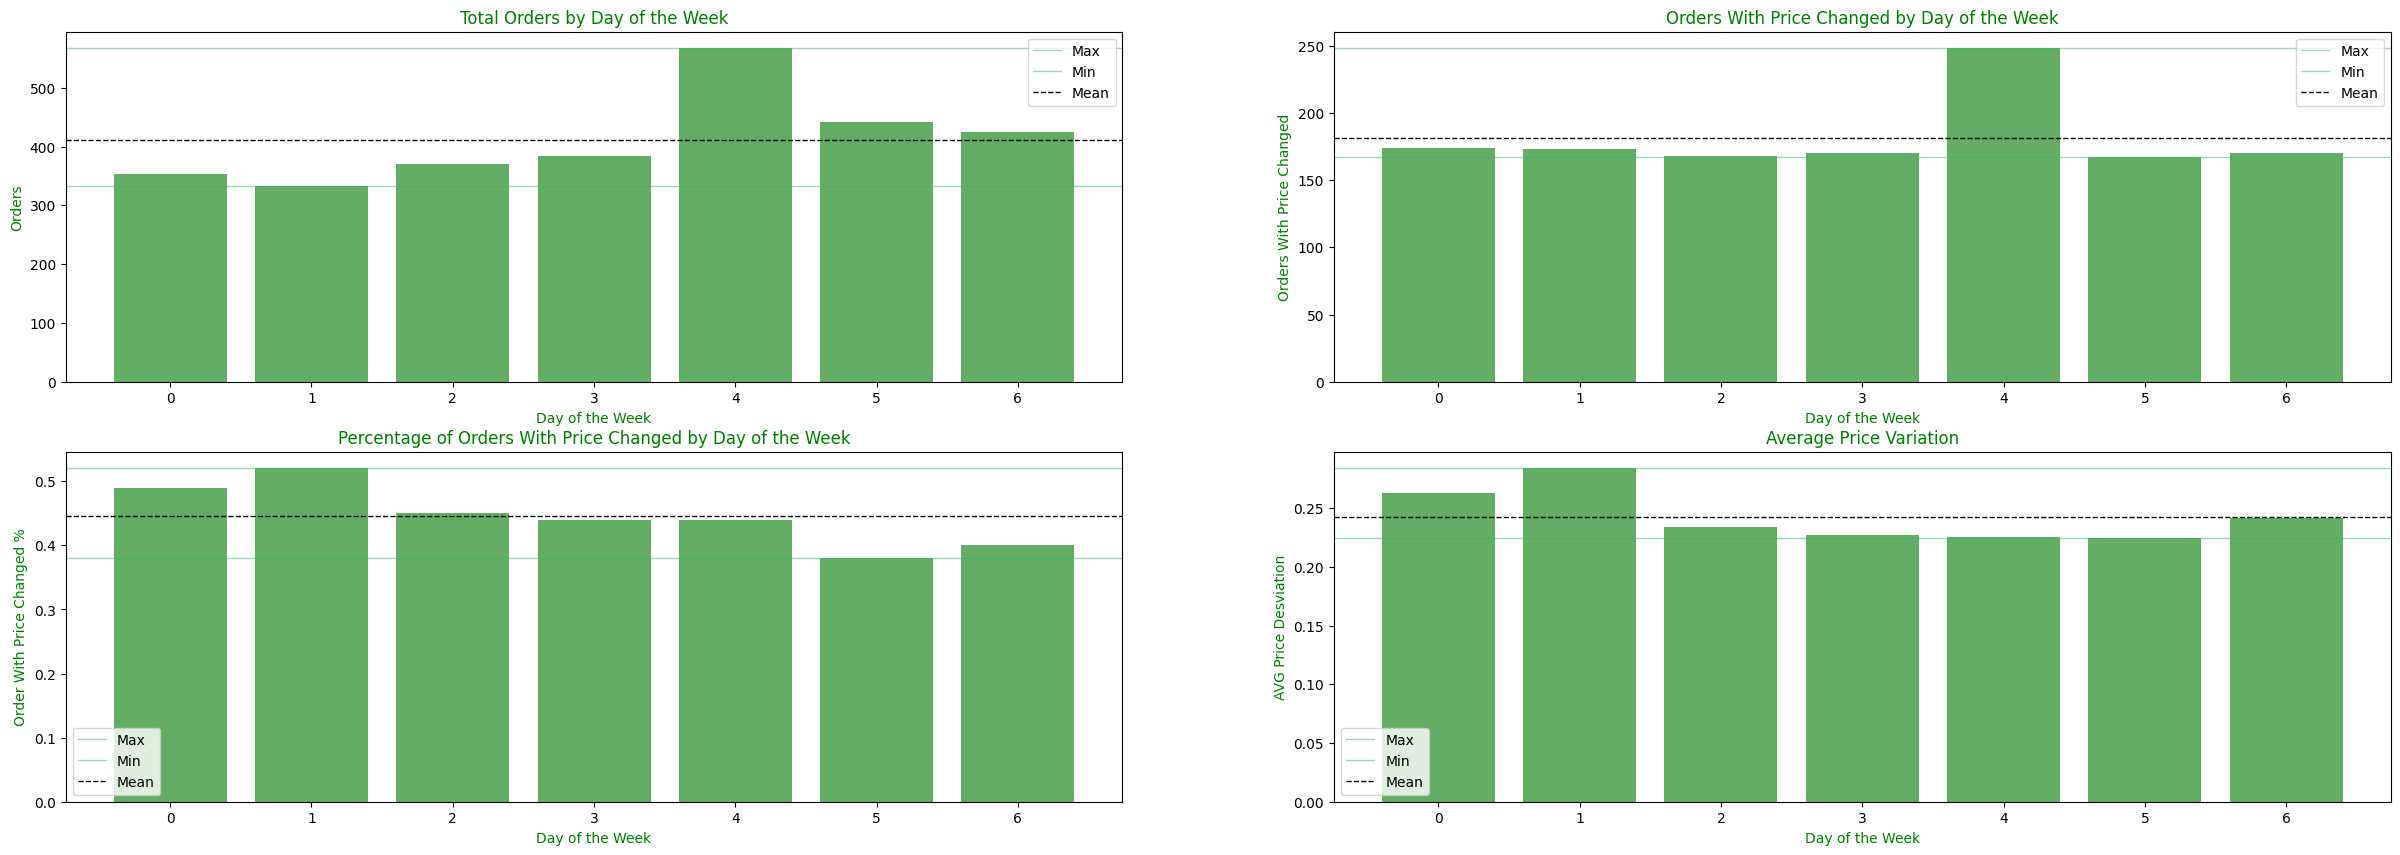

In [23]:
#Generate a timeline visualization

fig,ax = plt.subplots(nrows=2, ncols=2,figsize=(30,10))

ax[0,0].bar (x,y,color='ForestGreen',alpha=0.7)
ax[0,0].axhline(maximum, color='MediumSeaGreen',alpha=0.5,    linewidth=1, label='Max')
ax[0,0].axhline(minimum, color='MediumSeaGreen',alpha=0.5, linewidth=1, label='Min')
ax[0,0].axhline(mean, color='black', linestyle='--', linewidth=1, label='Mean')
ax[0,0].set_xlabel('Day of the Week',color='green')
ax[0,0].set_ylabel('Orders',color='green')
ax[0,0].set_title('Total Orders by Day of the Week',color='green')
ax[0,0].set_ylim(ymin=0)
ax[0,0].legend()

ax[0,1].bar (x2,y2,color='ForestGreen',alpha=0.7)
ax[0,1].axhline(maximum2, color='MediumSeaGreen',alpha=0.5,    linewidth=1, label='Max')
ax[0,1].axhline(minimum2, color='MediumSeaGreen',alpha=0.5, linewidth=1, label='Min')
ax[0,1].axhline(mean2, color='black', linestyle='--', linewidth=1, label='Mean')
ax[0,1].set_xlabel('Day of the Week',color='green')
ax[0,1].set_ylabel('Orders With Price Changed',color='green')
ax[0,1].set_title('Orders With Price Changed by Day of the Week',color='green')
ax[0,1].set_ylim(ymin=0)
ax[0,1].legend()

ax[1,0].bar (x3,y3,color='ForestGreen',alpha=0.7)
ax[1,0].axhline(maximum3, color='MediumSeaGreen',alpha=0.5,    linewidth=1, label='Max')
ax[1,0].axhline(minimum3, color='MediumSeaGreen',alpha=0.5, linewidth=1, label='Min')
ax[1,0].axhline(mean3, color='black', linestyle='--', linewidth=1, label='Mean')
ax[1,0].set_xlabel('Day of the Week',color='green')
ax[1,0].set_ylabel('Order With Price Changed %',color='green')
ax[1,0].set_title('Percentage of Orders With Price Changed by Day of the Week',color='green')
ax[1,0].set_ylim(ymin=0)
ax[1,0].legend()

ax[1,1].bar (x4,y4,color='ForestGreen',alpha=0.7)
ax[1,1].axhline(maximum4, color='MediumSeaGreen',alpha=0.5,    linewidth=1, label='Max')
ax[1,1].axhline(minimum4, color='MediumSeaGreen',alpha=0.5, linewidth=1, label='Min')
ax[1,1].axhline(mean4, color='black', linestyle='--', linewidth=1, label='Mean')
ax[1,1].set_xlabel('Day of the Week',color='green')
ax[1,1].set_ylabel('AVG Price Desviation',color='green')
ax[1,1].set_title('Average Price Variation',color='green')
ax[1,1].set_ylim(ymin=0)
ax[1,1].legend()


plt.show()

##### <span style="color:MediumSeaGreen">Analyze the combined impact of day of the week and hour of the day on order behavior</span>

In [24]:
# Calculate the total number of orders, the orders with price changes, and the average price variation for each combination of hour and day of the week.

orders_by_hour_day_temp = (df.groupby(['day_of_the_week_number','hour_of_the_day'])
                      .agg({'order_id_new': 'count', 'change_price':'sum','price_variation':'mean'})
                      .reset_index()
                      .rename(columns={'order_id_new':'total_orders','change_price':'orders_with_price_changed'}))

# New column to understand which percentage of orders changed the price
orders_by_hour_day_temp['orders_with_price_changed_percentage'] = orders_by_hour_day_temp['orders_with_price_changed'] / orders_by_hour_day_temp['total_orders']

In [25]:
# Create a table summarizing the number of orders based on the hour and day of the week.
orders_by_hour_day = orders_by_hour_day_temp.pivot_table(values='total_orders', index='day_of_the_week_number', columns='hour_of_the_day')

# Create a table summarizing the number of orders with price changed based on the hour and day of the week.
orders_with_price_changed_by_hour_day = orders_by_hour_day_temp.pivot_table(values='orders_with_price_changed', index='day_of_the_week_number', columns='hour_of_the_day')

# Create a table summarizing the price variation based on the hour and day of the week.
price_variation_by_hour_day = orders_by_hour_day_temp.pivot_table(values='price_variation', index='day_of_the_week_number', columns='hour_of_the_day')

# Create a table summarizing the percentage of orders with price changed based on the hour and day of the week.
orders_with_price_changed_perc_by_hour_day = orders_by_hour_day_temp.pivot_table(values='orders_with_price_changed_percentage', index='day_of_the_week_number', columns='hour_of_the_day')


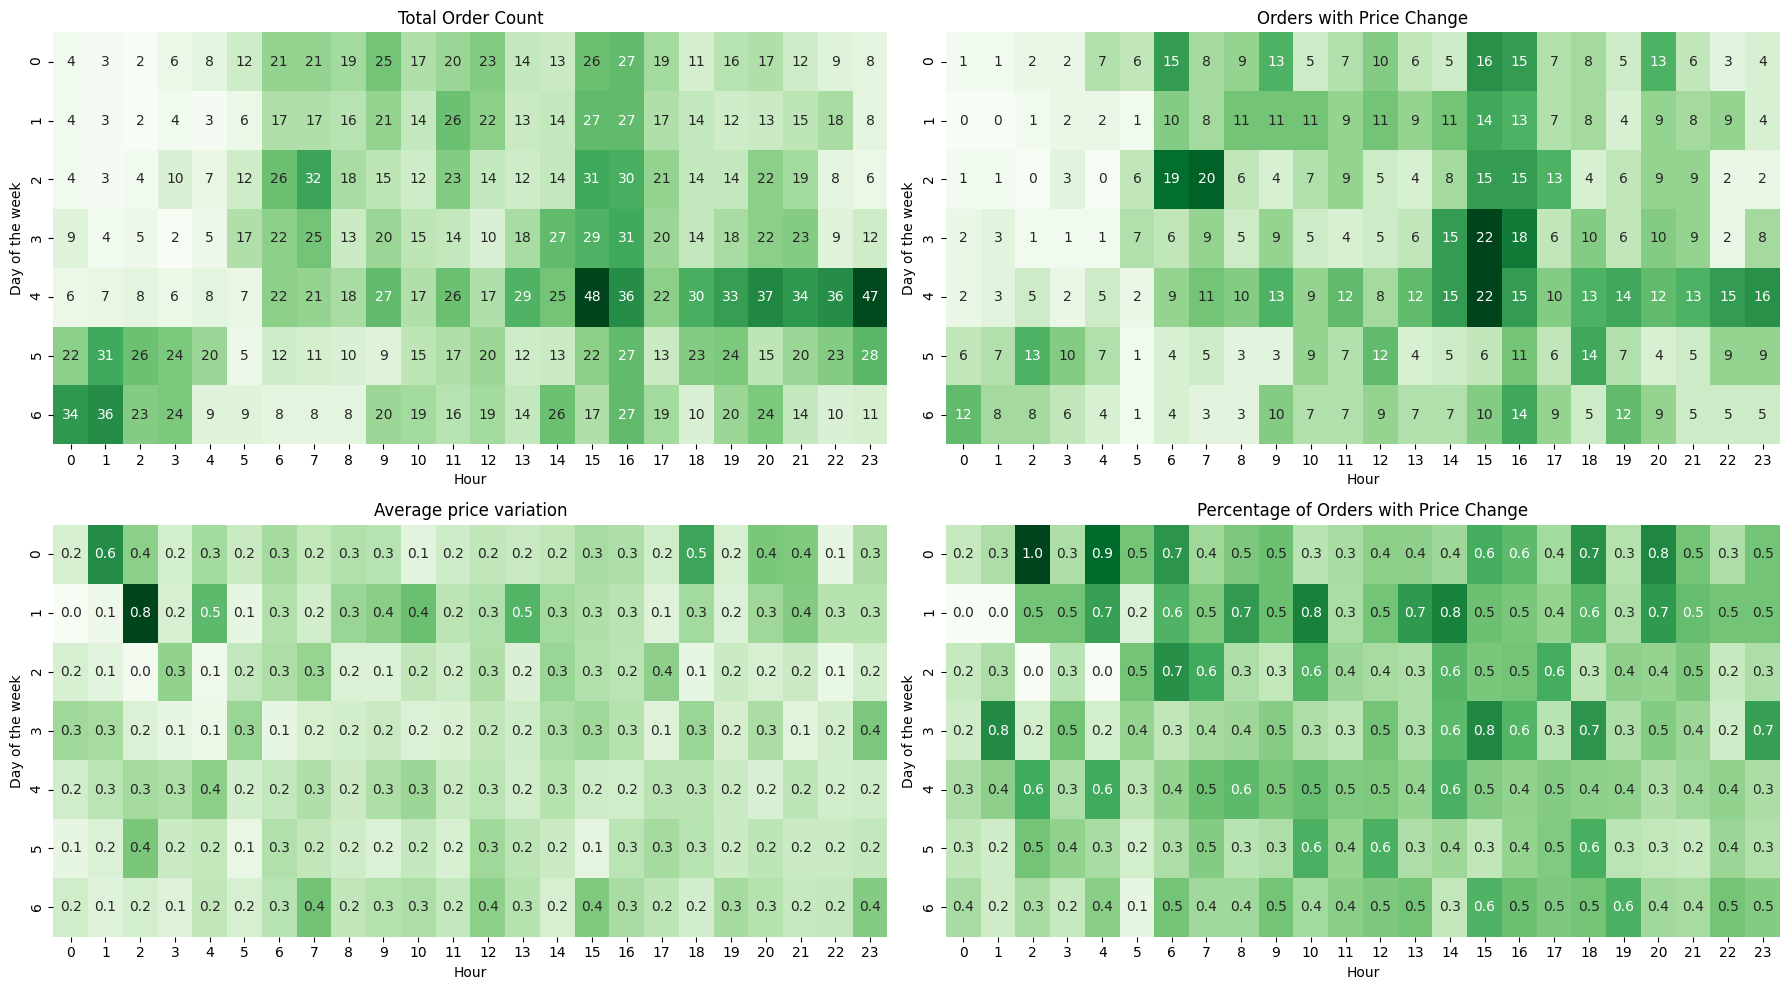

In [28]:
#Generate a Heatmap visualizations

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

# Total order count
sns.heatmap(orders_by_hour_day, annot=True, fmt='g', cmap='Greens', cbar=False, ax=axs[0,0])
axs[0,0].set_xlabel('Hour')
axs[0,0].set_ylabel('Day of the week')
axs[0,0].set_title('Total Order Count')

# Order count with price change
sns.heatmap(orders_with_price_changed_by_hour_day, annot=True, cmap='Greens', cbar=False, ax=axs[0,1])
axs[0,1].set_xlabel('Hour')
axs[0,1].set_ylabel('Day of the week')
axs[0,1].set_title('Orders with Price Change')

# Average Price variation
sns.heatmap(price_variation_by_hour_day, annot=True, fmt='.1f', cmap='Greens', cbar=False, ax=axs[1,0])
axs[1,0].set_xlabel('Hour')
axs[1,0].set_ylabel('Day of the week')
axs[1,0].set_title('Average price variation')

# Percentage of orders with price change relative to total
sns.heatmap(orders_with_price_changed_perc_by_hour_day, annot=True, fmt='.1f', cmap='Greens', cbar=False, ax=axs[1,1])
axs[1,1].set_xlabel('Hour')
axs[1,1].set_ylabel('Day of the week')
axs[1,1].set_title('Percentage of Orders with Price Change')

# Adjust spacing between subplots
plt.tight_layout()

# Show the heatmaps
plt.show()

#### <span style="color:MediumSeaGreen">GPS Confident Analysis</span>

In [29]:
# Determine the proportion of orders with GPS confident values, expressed as a percentage of the total orders.
round(df['gps_confidence'].value_counts() / df.shape[0],2)

1    0.92
0    0.08
Name: gps_confidence, dtype: float64

In [30]:
# Analyze the distribution of price, distance, and duration variation when GPS confidence is 0.
profiling_num(df[df['gps_confidence']=='0'][['price_variation','distance_variation','duration_variation']])

,variable,mean,std_dev,variation_coef,p_0.01,p_0.05,p_0.25,p_0.5,p_0.75,p_0.95,p_0.99
0,price_variation,0.550932,0.507430,0.921039,0.000000,0.009715,0.124074,0.393555,0.815485,1.682143,1.885215
1,distance_variation,0.595666,0.588545,0.988046,0.009789,0.027144,0.151254,0.422586,0.923417,1.598971,2.970859
2,duration_variation,0.823827,1.392150,1.689857,0.005901,0.023563,0.175452,0.468622,0.990747,2.688235,4.014102


In [31]:
# Analyze the distribution of price, distance, and duration variation when GPS confidence is 0
profiling_num(df[df['gps_confidence']=='1'][['price_variation','distance_variation','duration_variation']])

,variable,mean,std_dev,variation_coef,p_0.01,p_0.05,p_0.25,p_0.5,p_0.75,p_0.95,p_0.99
0,price_variation,0.212107,0.235471,1.110150,0.000000,0.000771,0.038761,0.138653,0.296671,0.654267,1.141651
1,distance_variation,0.268946,0.401857,1.494192,0.000727,0.003708,0.030526,0.128988,0.387637,0.984894,1.238049
2,duration_variation,0.389162,0.710411,1.825490,0.003450,0.016531,0.088505,0.215243,0.498349,1.108105,2.517658


In [32]:
# Determine the proportion of orders with GPS confidence 1 that exhibit a price variation higher than 20%.
df[df['gps_confidence']=='1']['price_variation'].quantile(0.58)

0.20194082332761581

In [33]:
# Determine the proportion of orders with GPS confidence 1 that exhibit a price variation higher than 20%.
df[df['gps_confidence']=='0']['price_variation'].quantile(0.34)

0.19832

In [34]:
# Compare the means between GPS confidence 1 and GPS confidence 0
(profiling_num(df[df['gps_confidence']=='0'][['price_variation','distance_variation','duration_variation']])['mean'] 
 / profiling_num(df[df['gps_confidence']=='1'][['price_variation','distance_variation','duration_variation']])['mean'])

0    2.597426
1    2.214817
2    2.116926
Name: mean, dtype: float64

In [35]:
# Conduct an analysis of selected categorical variables in cases where GPS confidence is 0
freq_tbl(df[df['gps_confidence']=='0'][['eu_indicator','device_brand']])

  eu_indicator  frequency  percentage  cumulative_perc
0            0        175    0.726141         0.726141
1            1         66    0.273859         1.000000

----------------------------------------------------------------

           device_brand  frequency  percentage  cumulative_perc
0                 TECNO         74    0.307054         0.307054
1               Samsung         53    0.219917         0.526971
2                HUAWEI         19    0.078838         0.605809
3               INFINIX         15    0.062241         0.668050
4                   HMD          9    0.037344         0.705394
5               Infinix          7    0.029046         0.734440
6                Xiaomi          7    0.029046         0.763485
7                  Itel          6    0.024896         0.788382
8             iPhone6,2          5    0.020747         0.809129
9               Foxconn          5    0.020747         0.829876
10            iPhone9,3          4    0.016598         0.846473


In [36]:
# Analyze the distribution of device brands in the DataFrame
freq_tbl(df['device_brand']).head()

,device_brand,frequency,percentage,cumulative_perc
0,Samsung,1135,0.394783,0.394783
1,HUAWEI,559,0.194435,0.589217
2,TECNO,257,0.089391,0.678609
3,Xiaomi,199,0.069217,0.747826
4,HMD,77,0.026783,0.774609


In [37]:
# Analyze the distribution of eu indicator in the DataFrame
freq_tbl(df['eu_indicator'])

,eu_indicator,frequency,percentage,cumulative_perc
0,1,2258,0.785391,0.785391
1,0,617,0.214609,1.000000


In [38]:
#Conduct an analysis of selected categorical variables in cases where GPS confidence is 1

freq_tbl(df[df['gps_confidence']=='1'][['eu_indicator','device_brand']])

  eu_indicator  frequency  percentage  cumulative_perc
0            1       2192    0.832194         0.832194
1            0        442    0.167806         1.000000

----------------------------------------------------------------

   device_brand  frequency  percentage  cumulative_perc
0       Samsung       1082    0.410782         0.410782
1        HUAWEI        540    0.205011         0.615793
2        Xiaomi        192    0.072893         0.688686
3         TECNO        183    0.069476         0.758162
4           HMD         68    0.025816         0.783979
..          ...        ...         ...              ...
67     TECNO_W4          1    0.000380         0.998481
68        SHARP          1    0.000380         0.998861
69        COSMO          1    0.000380         0.999241
70        KONKA          1    0.000380         0.999620
71      FUJITSU          1    0.000380         1.000000

[72 rows x 4 columns]

----------------------------------------------------------------



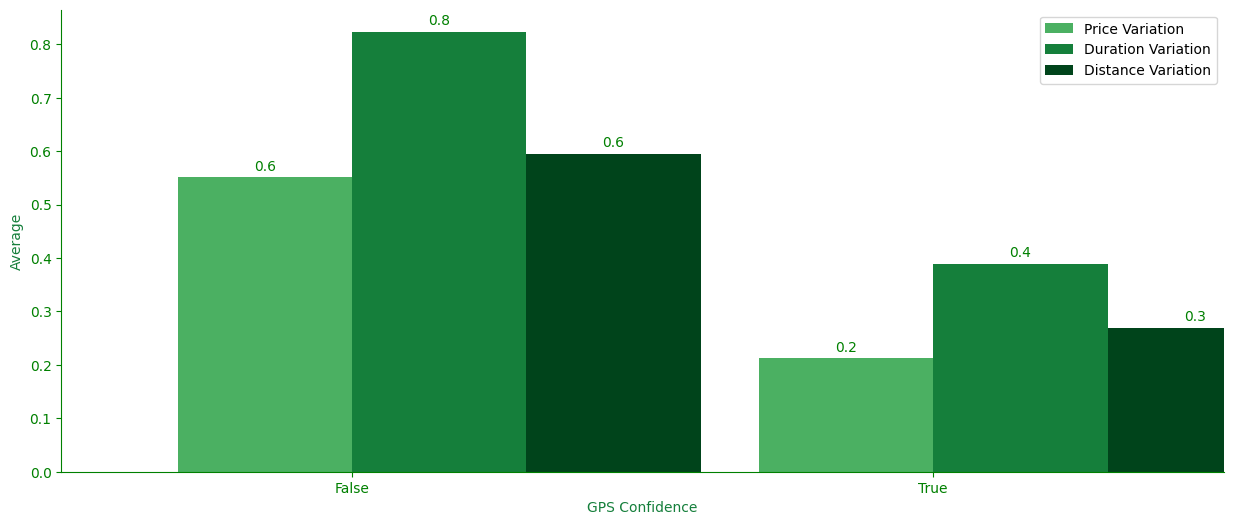

In [39]:
# Comparison of distance, duration, and price variations for each GPS confidence value.
# Group by gps_confidence and calculate the average of the numeric variables.
grouped = df.groupby('gps_confidence').mean()


# Create the bar chart.
labels = ['False', 'True']
x = np.arange(len(labels))
width = 0.3 

fig, ax = plt.subplots(figsize=(15, 6))

cmap = get_cmap('Greens')  # Paleta de colores en escala de verdes

bar1 = ax.bar(x - width/2, grouped['price_variation'], width, label='Price Variation', color=cmap(0.6))
bar2 = ax.bar(x + width/2, grouped['duration_variation'], width, label='Duration Variation', color=cmap(0.8))
bar3 = ax.bar(x + 3*width/2, grouped['distance_variation'], width, label='Distance Variation', color=cmap(1.0))

ax.set_xlabel('GPS Confidence', fontsize=10,color=cmap(0.8))
ax.set_ylabel('Average', fontsize=10,color=cmap(0.8))


# Adjust the spacing between the labels on the x-axis.
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=10)
ax.set_xlim(-0.5, 1.5)

ax.legend(fontsize=10)

# Add value labels to the bars.
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=10, color='green')

autolabel(bar1)
autolabel(bar2)
autolabel(bar3)

# Change the color of the axes to green.
ax.spines['bottom'].set_color('green')
ax.spines['left'].set_color('green')

# Change the color of the labels on the y-axis to green.
ax.tick_params(axis='y', colors='green')
ax.tick_params(axis='x', colors='green')

# Remove the borders of the chart.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# Adjust the spacing between the values on the x-axis.
ax.margins(x=2)

plt.show()

#### <span style="color:MediumSeaGreen">Destination Change Analysis</span>

In [41]:
# Determine the proportion of orders with Destination Change values, expressed as a percentage of the total orders.
round(df['dest_change_number'].value_counts() / df.shape[0],2)

1    0.96
3    0.02
2    0.02
4    0.00
5    0.00
7    0.00
Name: dest_change_number, dtype: float64

In [42]:
# Analyze the distribution of price, distance, and duration variation when GPS confidence is 0.
profiling_num(df[df['dest_change_number']>1][['price_variation','distance_variation','duration_variation']])

,variable,mean,std_dev,variation_coef,p_0.01,p_0.05,p_0.25,p_0.5,p_0.75,p_0.95,p_0.99
0,price_variation,0.406859,0.388904,0.955870,0.006272,0.026008,0.118919,0.277500,0.574468,1.250422,1.524673
1,distance_variation,0.392911,0.390080,0.992796,0.002690,0.009748,0.081307,0.264869,0.668581,1.079576,1.505669
2,duration_variation,0.715624,0.801866,1.120512,0.004075,0.031048,0.195122,0.480676,0.921182,2.212481,4.096344


In [43]:
# Analyze the distribution of price, distance, and duration variation when GPS confidence is 0.
profiling_num(df[df['dest_change_number']==1][['price_variation','distance_variation','duration_variation']])

,variable,mean,std_dev,variation_coef,p_0.01,p_0.05,p_0.25,p_0.5,p_0.75,p_0.95,p_0.99
0,price_variation,0.234204,0.278253,1.188083,0.00000,0.000759,0.040000,0.150000,0.315000,0.752806,1.423677
1,distance_variation,0.292673,0.431288,1.473620,0.00073,0.003821,0.033514,0.143161,0.411846,0.997330,1.537045
2,duration_variation,0.414604,0.797172,1.922728,0.00349,0.017094,0.090220,0.219022,0.515996,1.271623,2.910465


#### <span style="color:MediumSeaGreen">App version analysis</span>

In [44]:
# Determine the overall number of orders submitted by both clients and drivers
df['entered_by'].value_counts()

client    2828
driver      47
Name: entered_by, dtype: int64

In [45]:
# Create a subset DataFrame consisting of orders entered exclusively by clients
client_df = df[df['entered_by']=='client']

In [46]:
# Calculate the total count of orders and variations for each version of the rider app
pd.merge(client_df['rider_app_version'].value_counts().reset_index().rename(columns={'index':'rider_app_version','rider_app_version':'orders'}),
         client_df.groupby('rider_app_version')[['price_variation','distance_variation','duration_variation']]
         .mean().reset_index(), how= 'left', on='rider_app_version').head(15)

,rider_app_version,orders,price_variation,distance_variation,duration_variation
0,CI.4.17,506,0.246828,0.289533,0.471962
1,CI.4.19,378,0.214676,0.264794,0.403747
2,CA.5.44,288,0.206137,0.260628,0.334086
3,CA.5.43,278,0.239799,0.296629,0.396678
4,CA.5.42,220,0.281812,0.338260,0.487154
5,CI.4.18,174,0.200918,0.222647,0.316130
6,CA.5.46,125,0.209738,0.255251,0.396677
7,CA.5.45,115,0.217001,0.256352,0.373185
8,CA.5.36,89,0.302311,0.380259,0.506191
9,CI.4.14,84,0.232492,0.295269,0.406834


In [47]:
# Calculate the total number of clients for both iOS and Android platforms
client_df['rider_operative_system'].value_counts()

CA    1495
CI    1333
Name: rider_operative_system, dtype: int64

In [48]:
## Calculate the total count of orders and variations for each version of the rider app specifically on iPhone
pd.merge(client_df[client_df['rider_operative_system'] == 'CI']['rider_app_version'].value_counts().reset_index()
         .rename(columns={'index':'rider_app_version','rider_app_version':'orders'}),client_df[client_df['rider_operative_system'] == 'CI']
         .groupby('rider_app_version')[['price_variation','distance_variation','duration_variation']]
         .mean().reset_index(), how= 'left', on='rider_app_version').head(15)

,rider_app_version,orders,price_variation,distance_variation,duration_variation
0,CI.4.17,506,0.246828,0.289533,0.471962
1,CI.4.19,378,0.214676,0.264794,0.403747
2,CI.4.18,174,0.200918,0.222647,0.316130
3,CI.4.14,84,0.232492,0.295269,0.406834
4,CI.4.22,27,0.163120,0.238177,0.210791
5,CI.4.13,23,0.215128,0.299404,0.421453
6,CI.4.23,21,0.170023,0.231959,0.187228
7,CI.4.11,15,0.280458,0.338549,0.367639
8,CI.4.04,11,0.236423,0.288424,0.440098
9,CI.4.09,10,0.115377,0.207477,0.208970


In [49]:
# Calculate the total count of orders and variations for each version of the rider app specifically on Android
pd.merge(client_df[client_df['rider_operative_system'] == 'CA']['rider_app_version'].value_counts().reset_index()
         .rename(columns={'index':'rider_app_version','rider_app_version':'orders'}),client_df[client_df['rider_operative_system'] == 'CA']
         .groupby('rider_app_version')[['price_variation','distance_variation','duration_variation']]
         .mean().reset_index(), how= 'left', on='rider_app_version').head(15)

,rider_app_version,orders,price_variation,distance_variation,duration_variation
0,CA.5.44,288,0.206137,0.260628,0.334086
1,CA.5.43,278,0.239799,0.296629,0.396678
2,CA.5.42,220,0.281812,0.338260,0.487154
3,CA.5.46,125,0.209738,0.255251,0.396677
4,CA.5.45,115,0.217001,0.256352,0.373185
5,CA.5.36,89,0.302311,0.380259,0.506191
6,CA.5.40,65,0.305030,0.351103,0.596563
7,CA.5.47,47,0.332770,0.675584,0.580212
8,CA.5.32,40,0.257918,0.333878,0.441182
9,CA.5.38,27,0.291876,0.264781,0.539304


#### <span style="color:MediumSeaGreen">Device analysis</span>

In [50]:
# Calculate the total count of orders and variations for each device
pd.merge(df['device_name'].value_counts().reset_index().rename(columns={'index':'device_name','device_name':'orders'}),
         df.groupby('device_name')[['price_variation','distance_variation','duration_variation']]
         .mean().reset_index(), how= 'left', on='device_name').head(20)

,device_name,orders,price_variation,distance_variation,duration_variation
0,"iPhone8,1",60,0.196592,0.256609,0.292154
1,HUAWEI MAR-LX1A,59,0.199045,0.277749,0.265233
2,Samsung SM-A505FN,59,0.165328,0.189051,0.248915
3,Samsung SM-A520F,54,0.256606,0.316639,0.499628
4,Samsung SM-G960F,51,0.265173,0.298364,0.363610
5,"iPhone9,3",48,0.222696,0.447858,0.305389
6,HUAWEI KOB-L09,46,0.178402,0.253426,0.238950
7,HUAWEI ANE-LX1,45,0.229643,0.267661,0.425289
8,Samsung SM-G950F,41,0.177025,0.217004,0.253838
9,Samsung SM-G930F,41,0.255794,0.324040,0.456275


In [51]:
# Calculate the total count of orders and variations for each device brand
pd.merge(df['device_brand'].value_counts().reset_index().rename(columns={'index':'device_brand','device_brand':'orders'}),
         df.groupby('device_brand')[['price_variation','distance_variation','duration_variation']]
         .mean().reset_index(), how= 'left', on='device_brand').head(20)

,device_brand,orders,price_variation,distance_variation,duration_variation
0,Samsung,1135,0.212948,0.253289,0.385833
1,HUAWEI,559,0.215001,0.251874,0.343165
2,TECNO,257,0.379951,0.493582,0.721042
3,Xiaomi,199,0.205805,0.251354,0.456251
4,HMD,77,0.294819,0.295907,0.538985
5,"iPhone8,1",60,0.196592,0.256609,0.292154
6,INFINIX,56,0.401917,0.438067,0.672397
7,"iPhone9,3",48,0.222696,0.447858,0.305389
8,Sony,35,0.235291,0.254141,0.471704
9,Itel,33,0.349719,0.537658,0.519926


#### <span style="color:MediumSeaGreen">EU Indicator Analysis</span>

In [52]:
# Calculate the total number of orders based on the EU indicator.
df['eu_indicator'].value_counts()

1    2258
0     617
Name: eu_indicator, dtype: int64

In [53]:
# Analyze the distribution of variations specifically for European orders

profiling_num(df[df['eu_indicator']=='1'][['price_variation','distance_variation','duration_variation']])

,variable,mean,std_dev,variation_coef,p_0.01,p_0.05,p_0.25,p_0.5,p_0.75,p_0.95,p_0.99
0,price_variation,0.204765,0.227971,1.113329,0.000000,0.002911,0.037500,0.133568,0.285962,0.642489,1.059562
1,distance_variation,0.252785,0.400700,1.585144,0.000724,0.003462,0.027022,0.119221,0.363684,0.969182,1.272810
2,duration_variation,0.340160,0.688394,2.023734,0.003346,0.014940,0.078519,0.187336,0.418336,0.992439,2.278530


In [54]:
# Analyze the distribution of variations specifically for Non-European orders
profiling_num(df[df['eu_indicator']=='0'][['price_variation','distance_variation','duration_variation']])

,variable,mean,std_dev,variation_coef,p_0.01,p_0.05,p_0.25,p_0.5,p_0.75,p_0.95,p_0.99
0,price_variation,0.371322,0.407707,1.097987,0.000000,0.000000,0.072818,0.238767,0.551831,1.291075,1.785337
1,distance_variation,0.455706,0.492743,1.081274,0.001943,0.013809,0.086768,0.273137,0.767409,1.227092,2.351842
2,duration_variation,0.738271,1.057844,1.432867,0.006433,0.039701,0.195241,0.498891,0.926904,2.155994,4.143727


In [55]:
# Calculate the total number of orders with price changes specifically for Non-European orders.
df[df['eu_indicator']=='0']['change_price'].value_counts()

True     327
False    290
Name: change_price, dtype: int64

#### <span style="color:MediumSeaGreen">Explore the overall correlations between variables </span>

In [56]:
# Calculate the correlation between numerical variables, particularly to identify any variables that may have an impact on the price variation.
df.corr()[['price_variation','duration_variation','distance_variation','distance_per_minute_predicted']]

,price_variation,duration_variation,distance_variation,distance_per_minute_predicted
metered_price,0.334312,0.196351,0.146988,-0.136833
upfront_price,0.174046,0.076467,0.094562,-0.065519
distance,0.120950,-0.024019,-0.035916,0.484038
duration,0.328196,0.282253,0.014203,-0.060574
dest_change_number,0.116192,0.074306,0.042938,0.013654
predicted_distance,0.071609,-0.029610,-0.026237,0.282019
predicted_duration,0.146260,-0.007119,0.005602,0.091102
fraud_score,-0.011362,-0.020586,-0.016793,0.141411
total_tickets_per_order,0.064648,0.077834,0.047811,-0.087495
overpaid_tickets_per_order,0.167614,0.084822,0.105043,-0.062883


In [57]:
# Analyze the distribution of duration for orders with a price change
profiling_num(df[df['change_price']==True]['duration'])

,variable,mean,std_dev,variation_coef,p_0.01,p_0.05,p_0.25,p_0.5,p_0.75,p_0.95,p_0.99
0,duration,1370.735433,1358.466993,0.99105,8.38,119.9,611.5,991.0,1639.5,4019.55,6109.29


In [58]:
# Analyze the distribution of duration for orders without a price change.
profiling_num(df[df['change_price']==False]['duration'])

,variable,mean,std_dev,variation_coef,p_0.01,p_0.05,p_0.25,p_0.5,p_0.75,p_0.95,p_0.99
0,duration,989.47352,784.858878,0.793209,53.12,248.2,492.0,796.0,1260.0,2413.6,3950.92


## <span style="color:MediumSeaGreen">Key Findings</span>

##### <span style="color:MediumSeaGreen">Explore patterns and trends related to dates in the dataset.</span>

###### <span style="color:MediumSeaGreen">Analyze the behavior of orders based on hour of the day</span>

- Lack of high peaks in hourly analysis: The analysis of price variation throughout the hours of the day does not reveal significant spikes, indicating a relatively consistent pattern. The price variation tends to remain close to the mean value.

###### <span style="color:MediumSeaGreen">Analyze patterns and trends in order behavior across different days of the week</span>

- Lack of significant peaks in day-of-the-week analysis: The analysis of price variation across different days of the week does not exhibit notable spikes, indicating a consistent pattern. The price variation tends to remain close to the mean value.

###### <span style="color:MediumSeaGreen">Analyze the combined impact of day of the week and hour of the day on order behavior</span>

- ⭐ **Limited correlation: No strong relation between total orders and price variation/orders with price changed**

##### <span style="color:MediumSeaGreen">⭐ GPS Confident Analysis</span>

- GPS connection issues: Approximately 8% of the orders are affected by a bad GPS connection.

- ⭐ **Price variation comparison: Orders with bad GPS connection have an average price variation of 55%, while orders with good connection experience an average variation of 21%.**

- Significant price variation: For orders with bad GPS connection, more than half of them (50%) exhibit a price variation exceeding 39% while for orders with good GPS connection only the 16% exceds the 39% of price variation.

- Price variation impact: Among orders with bad GPS connection, a significant majority (66%) experience a price variation higher than 20%. In contrast, for orders with good GPS connection, this number decreases to 42%

- Higher averages for bad GPS connection: On average, orders with bad GPS connection show higher values than twice that of orders with good connection in terms of price, distance, and duration.

- ⭐ **Prevalence of non-European cases: Out of the orders with bad GPS connection, 73% are from non-European regions, in contrast to the overall dataframe where non-Europeans account for 21%.**

- TECNO device association: TECNO devices are found in 31% of the orders with bad GPS connection, compared to the 9% occurrence of TECNO devices in the entire dataframe.

##### <span style="color:MediumSeaGreen">Destination Change Analysis</span>

- Inadequate data for conclusive insights: The number of rows with more than 1 destination change is insufficient to draw meaningful conclusions or insights from the analysis.

##### <span style="color:MediumSeaGreen">Explore the overall correlations between variables</span>

- No additional insights beyond the current analysis: The analysis conducted so far does not provide any additional significant information or insights.

##### <span style="color:MediumSeaGreen">⭐ App version analysis</span>

###### <span style="color:MediumSeaGreen">Drivers</span>

- Inadequate number of orders for conclusive insights: The limited number of orders entered by drivers hinders the ability to draw meaningful and conclusive insights from the analysis.

##### <span style="color:MediumSeaGreen">Riders</span>

###### <span style="color:MediumSeaGreen">Android</span>

- The most commonly used version, CA.5.44, exhibits one of the lowest average price variations (20%).
- ⭐ **Older versions (CA.5.43/42) rank second in terms of usage but demonstrate higher average price variations (25%) and particularly higher average duration variations.**
- ⭐ **The newest version, CA.5.47, currently displays significantly higher average price and duration variations compared to the older versions. Further investigation is required to determine if any changes can be made to align it with the successful system employed by CA.5.44 in a future update, thus improving these metrics.**

###### <span style="color:MediumSeaGreen">IOs</span>

- ⭐ **Prevalence of orders from old version: The majority of orders (66%) are from the old version (CI.4.17/19), which exhibits an average price variation of approximately 23% and duration variation of approximately 43%. In contrast, the new version (CI.4.22/23) comprises a smaller proportion of orders (3.6%), with an average price variation of approximately 16.5% and duration variation of approximately 20%.**


##### <span style="color:MediumSeaGreen">Device analysis</span>

- TECNO devices account for 9% of the total orders, exhibiting an average price variation of 38%, which is significantly higher than most other device brands. Additionally, the average duration variation for TECNO device orders is 72%.
- It is important to note that all orders made from TECNO devices are from non-European regions, and these orders consistently demonstrate the same high average price variation and duration variation.


##### <span style="color:MediumSeaGreen">⭐ EU Indicator Analysis</span>

- 21% of the orders are non european
- ⭐ **Non-european orders have an average price variation three times bigger than european orders**
- 54% of the orders have the price changed

##### <span style="color:MediumSeaGreen">Explore the overall correlations between variables</span>

- Orders with higher price deviation tend to have a higher final distance traveled.
- However, due to the distribution's high standard deviation, confirming a strong and definitive correlation is challenging.